# Capstone project

The success of a new business depends on a number of factors, one of them is to perform market research. Market research allows a prospective business owner to identify gaps in supply as well as determine if an area has demand for their goods. Doing this research will ensure a new business is set up for success and their hard work does not go to waste, however it is currently very time consuming.

This project aims to identify demand for diffrent types of cuisines based on availability and population demand. The findings will allow new restaurant owners to decide what type of food they will serve

Note: For the purpose of this project, and scope of this project will only target Canada and be limited to food items.

## Data

This project will utilize data from several sources:
1. Geospatial data will be gatherd from www.geonames.org
2. Census data from Statistics Canada https://www.statcan.gc.ca/
3. Current business/venue data from https://foursquare.com/

The geospatial and census data will be combined to form a larger dataset, the data will be joined by post code. Finally the FourSquare API will be used to identify restaurants within a 30KM radius. The responses from FourSquare will be cached due to rate limitations on the API.

Once all of the data has been gatherd, analysis can be preformed to identify the best types of cuisines for a new business to sell.

To start off, all of the relevent libraries for this project needs to be imported and the data has to be gathered

In [782]:
# Load the relevant libraries
import re 
import os
import glob
import json
import ntpath
import operator
import requests
import matplotlib
import numpy as np
import pandas as pd
import tqdm as tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


In [697]:
# Read the geospatial data
geoCols = ['country code','postal code','place name',
           'state name','state code',
           'admin name2','admin code2',
           'admin name3','admin code3',
           'latitude','longitude','accuracy']
geospatialdf = pd.read_csv('Data/CA.csv',names=geoCols,header=None)
geospatialdf['place name'] = geospatialdf['place name'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x)) 
print(geospatialdf.shape)
geospatialdf.head()

(1656, 12)


,country code,postal code,place name,state name,state code,admin name2,admin code2,admin name3,admin code3,latitude,longitude,accuracy
0,CA,T0A,Eastern Alberta,Alberta,AB,NaN,NaN,NaN,NaN,54.7660,-111.7174,6.0
1,CA,T0B,Wainwright Region,Alberta,AB,NaN,NaN,NaN,NaN,53.0727,-111.5816,6.0
2,CA,T0C,Central Alberta,Alberta,AB,NaN,NaN,NaN,NaN,52.1431,-111.6941,5.0
3,CA,T0E,Western Alberta,Alberta,AB,NaN,NaN,NaN,NaN,53.6758,-115.0948,5.0
4,CA,T0G,North Central Alberta,Alberta,AB,NaN,NaN,NaN,NaN,55.6993,-114.4529,6.0


In [698]:
# Read the census data
censusdf = pd.read_csv('Data/CanadaPopByPostCode.CSV')
censusdf.columns.values[0] = 'postal code'
print(censusdf.shape)
censusdf.head()

(1650, 7)


,postal code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,1,Canada,NaN,T,35151728.0,15412443.0,14072079.0
1,A0A,A0A,Newfoundland and Labrador,NaN,46587.0,26155.0,19426.0
2,A0B,A0B,Newfoundland and Labrador,NaN,19792.0,13658.0,8792.0
3,A0C,A0C,Newfoundland and Labrador,NaN,12587.0,8010.0,5606.0
4,A0E,A0E,Newfoundland and Labrador,NaN,22294.0,12293.0,9603.0


In [699]:
# The dataframes need to be merged
df = pd.merge(geospatialdf, censusdf, on=['postal code'], how='inner')

# Only keep columns that are nessary for analysis 
colsToKeep = ['postal code', 'place name', 'state name', 'state code', 'latitude', 'longitude', 'Population, 2016']
df = df[colsToKeep]

print(df.shape)
df.head()

(1642, 7)


,postal code,place name,state name,state code,latitude,longitude,"Population, 2016"
0,T0A,Eastern Alberta,Alberta,AB,54.7660,-111.7174,59234.0
1,T0B,Wainwright Region,Alberta,AB,53.0727,-111.5816,64072.0
2,T0C,Central Alberta,Alberta,AB,52.1431,-111.6941,62701.0
3,T0E,Western Alberta,Alberta,AB,53.6758,-115.0948,43729.0
4,T0G,North Central Alberta,Alberta,AB,55.6993,-114.4529,42905.0


In [700]:
CLIENT_ID = '1302RZYNQ1230HZLKHKYDGSXUTDXRNLPWXIMMZE5BUHJWROH' # your Foursquare ID
CLIENT_SECRET = 'MWGGKWCYMXGYSNRL2UPTVC5BETYDNIDHN12MRY3Z4ODGWHEI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 999
RADIUS = 30000 # 30 kms
CATEGORYID = '4d4b7105d754a06374d81259' # Food items

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1302RZYNQ1230HZLKHKYDGSXUTDXRNLPWXIMMZE5BUHJWROH
CLIENT_SECRET:MWGGKWCYMXGYSNRL2UPTVC5BETYDNIDHN12MRY3Z4ODGWHEI


The code block below contains several functions and code that allow the retrieval of venue data from Foursquare and caching the response. Caching the response avoids unnessary calls to the Foursquare API - this is also very time saving as i am making over 1600 calls to the API

In [701]:
from requests_testadapter import Resp

class LocalFileAdapter(requests.adapters.HTTPAdapter):
    def build_response_from_file(self, request):
        file_path = request.url[7:]
        with open(file_path, 'rb') as file:
            buff = bytearray(os.path.getsize(file_path))
            file.readinto(buff)
            resp = Resp(buff)
            r = self.build_response(request, resp)

            return r

    def send(self, request, stream=False, timeout=None,
             verify=True, cert=None, proxies=None):

        return self.build_response_from_file(request)

requests_session = requests.session()
requests_session.mount('file://', LocalFileAdapter())

def path_leaf(path):
    """This function gets the file name from a path"""
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

cacheDir = os.path.abspath(os.path.join('Data','Foursquare','Json'))
currentCacheKeys = glob.glob(os.path.join(cacheDir, "*"))
currentCacheVals = [requests_session.get('file://'+x).json() for x in currentCacheKeys]
requestCache = {}

for x,y in zip(currentCacheKeys,currentCacheVals):
    requestCache[path_leaf(x)] = y


def getNearbyVenuesCached(names, latitudes, longitudes,populations):
    venues_list=[]
    for name, lat, lng, pops in tqdm.tqdm(zip(names, latitudes, longitudes, populations)):
        key = str(lat)+str(lng)+str(RADIUS)+str(LIMIT)+str(CATEGORYID)+'.json'
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT,
            CATEGORYID)
        
        # make the GET request
        data = None
        if key in requestCache:
            try:
                data = requestCache[key]["response"]['groups'][0]['items']
            except:
                continue
        else:
            data = requests.get(url).json()
            with open(cacheDir+'\\'+key, 'w') as outfile:
                json.dump(data, outfile)
            requestCache[key]=data
            try:
                data = data["response"]['groups'][0]['items']         
            except:
                continue

        results = data
        
        
        
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(
                name, 
                v['venue']['location']['state'],
                lat, 
                lng, 
                pops,
                v['venue']['name'],                 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            continue

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'State',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Population',
                  'Venue',                   
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [702]:
venues = getNearbyVenuesCached(df['place name'],df['latitude'],df['longitude'],df['Population, 2016'])
venues['Venue'] = venues['Venue'].apply(lambda x: re.sub(".*subway", "subway", x.lower())) 
print('The Foursquare API retrieved '+str(venues.shape[0])+' records')

1642it [00:00, 15112.32it/s]


The Foursquare API retrieved 33707 records


In [703]:
# Preform some data cleanup, https://www.ncbi.nlm.nih.gov/books/NBK7254/
venues['State'] = venues['State'].str.replace('Québec','QC')
venues['State'] = venues['State'].str.replace('Maine','ME')
venues['State'] = venues['State'].str.replace('Manitoba','MB')
venues['State'] = venues['State'].str.replace('E1W 1A5','NB')
venues['State'] = venues['State'].str.replace('Nova Scotia','NS')
venues['State'] = venues['State'].str.replace('Ont','ON')
venues['State'] = venues['State'].str.replace('New Brunswick','NB')
venues['State'] = venues['State'].str.replace('Prince Edward Island','PE')
venues['State'] = venues['State'].str.replace('PQ','QC')
venues['State'] = venues['State'].str.replace('Northwest Territorie','NT')
venues['State'] = venues['State'].str.replace('J6R 1A5','QC')
venues['State'] = venues['State'].str.replace('British Colombia','BC')
venues['State'] = venues['State'].str.replace('ONario','ON')
venues['State'] = venues['State'].str.replace('PEI','PE')

# WA, ME, NY, MI is in the US
venues = venues[venues['State']!='WA']
venues = venues[venues['State']!='ME']
venues = venues[venues['State']!='NY']
venues = venues[venues['State']!='MI']


In [704]:
# Append the rest of the cencus data based on the location of the venue

NameToStateAb= {'Alberta':'AB',
    'British Columbia':'BC',
    'Manitoba':'MB',
    'New Brunswick':'NB',
    'Newfoundland and Labrador':'NL',
    'Northwest Territories':'NT',
    'Nova Scotia':'NS',
    'Nunavut':'NU',
    'Ontario':'ON',
    'Prince Edward Island':'PE',
    'Quebec':'QC',
    'Saskatchewan':'SK',
    'Yukon':'YT'}

# Load and prepare the new cencus data
censusdf1 = pd.read_csv('Data/DetailedPopData.CSV')
censusdf1['feature'] = censusdf1['Topic'] + ' ' + censusdf1['Characteristics']
censusdf1 = censusdf1[['Prov_Name','feature','Total']]
censusdf1 = censusdf1.groupby(['Prov_Name','feature']).sum()
censusdf1.reset_index(inplace=True)
censusdf1 = censusdf1.pivot(index='Prov_Name', columns='feature',values ='Total')
censusdf1.reset_index(inplace=True)
censusdf1['Prov_Name'] = censusdf1['Prov_Name'].apply(lambda x: NameToStateAb[x]) 
censusdf1.rename(columns={'Prov_Name':'State'}, inplace=True)

# Attach it to the venues dataframe
venues = venues[venues['State'].isin(censusdf1['State'].unique())]
venues = pd.merge(venues1, censusdf1, on=['State'], how='inner')

In [716]:
print('After data cleanup and merging, '+str(venues1.shape[0])+' records are left')

After data cleanup and merging, 25400 records are left


In [721]:
venues.head()

,Neighborhood,State,Neighborhood Latitude,Neighborhood Longitude,Population,Venue,Venue Latitude,Venue Longitude,Venue Category,Age characteristics 15 years_x,...,Marital status Married or living with a common-law partner_y,Marital status Not married and not living with a common-law partner_y,Marital status Total population 15 years and over by marital status_y,Population and dwelling counts 2006 to 2011 population change (%)_y,Population and dwelling counts Land area (square km)_y,Population and dwelling counts Population density per square kilometre_y,Population and dwelling counts Population in 2006_y,Population and dwelling counts Population in 2011_y,Population and dwelling counts Private dwellings occupied by usual residents_y,Population and dwelling counts Total private dwellings_y
0,Bathurst,NB,47.6181,-65.6511,17205.0,danny's inn,47.672448,-65.690419,Restaurant,8740.0,...,382240.0,255250.0,637565.0,-473.3,71377.21,20233.6,729997.0,751171.0,314007.0,348465.0
1,Bathurst,NB,47.6181,-65.6511,17205.0,mai's restaurant,47.634312,-65.673062,Vietnamese Restaurant,8740.0,...,382240.0,255250.0,637565.0,-473.3,71377.21,20233.6,729997.0,751171.0,314007.0,348465.0
2,Bathurst,NB,47.6181,-65.6511,17205.0,atlantic host,47.638616,-65.703121,Restaurant,8740.0,...,382240.0,255250.0,637565.0,-473.3,71377.21,20233.6,729997.0,751171.0,314007.0,348465.0
3,Bathurst,NB,47.6181,-65.6511,17205.0,subway,47.620591,-65.656043,Sandwich Place,8740.0,...,382240.0,255250.0,637565.0,-473.3,71377.21,20233.6,729997.0,751171.0,314007.0,348465.0
4,Bathurst,NB,47.6181,-65.6511,17205.0,nectar,47.621048,-65.658811,Restaurant,8740.0,...,382240.0,255250.0,637565.0,-473.3,71377.21,20233.6,729997.0,751171.0,314007.0,348465.0


## Analysis

Now that all of the data has been gathered some analysis will need to be performed to get a greater understanding of the data and how it can help solve the problem

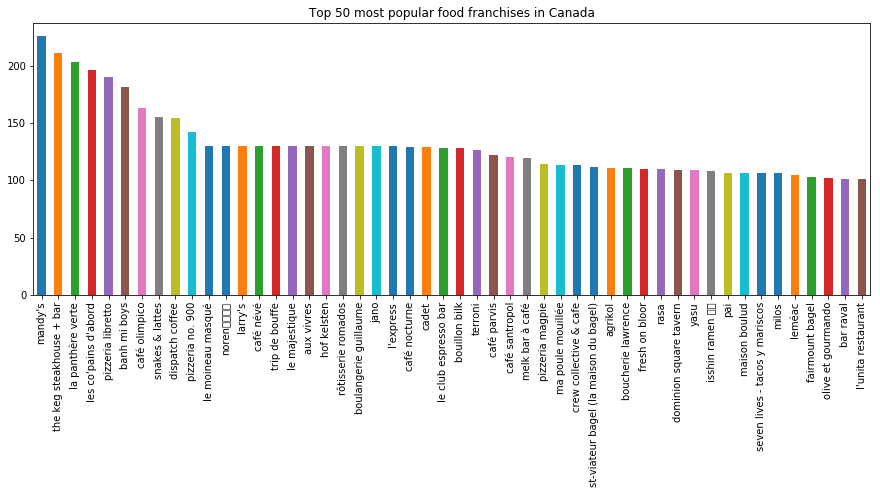

In [728]:
matplotlib.rcParams['figure.figsize'] = [15, 5]
venues['Venue'].value_counts().head(50).plot(kind='bar',
                                             title='Top 50 most popular food franchises in Canada')

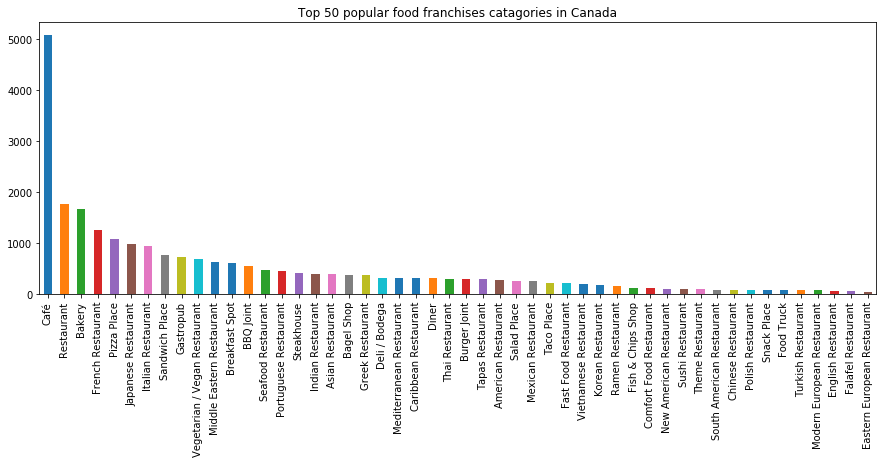

In [729]:
matplotlib.rcParams['figure.figsize'] = [15, 5]
venues['Venue Category'].value_counts().head(50).plot(kind='bar', title='Top 50 popular food franchises catagories in Canada')

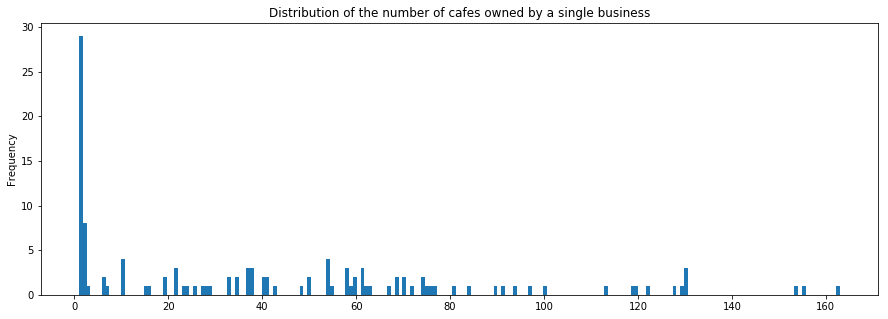

In [730]:
matplotlib.rcParams['figure.figsize'] = [15, 5]
venues[venues['Venue Category'] == 'Café']['Venue'].value_counts().plot(kind='hist',bins=200, title='Distribution of the number of cafes owned by a single business')

The charts above validate that is possible to thrive as a small business in Canada. Cafés are the most popular type of venue in Canada, within that catagory it is evident that most of them are small businesses with less than 5 total stores.

## Modeling

While we have a large dataset, it is important to understand that it is a sample and it is not completely representative of the population. One of the reasons for this is due to the fact the Foursquare API can only return 100 venues for a given place. This means that when we aggregate the dataset, every record where the venue count is 100 may actually mean that there are more than 100 venues; we can somewhat solve this problem with machine learning. To determine the best algrothim to use a little bit of data analysis is needed.


c:\program files\python37\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python37\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


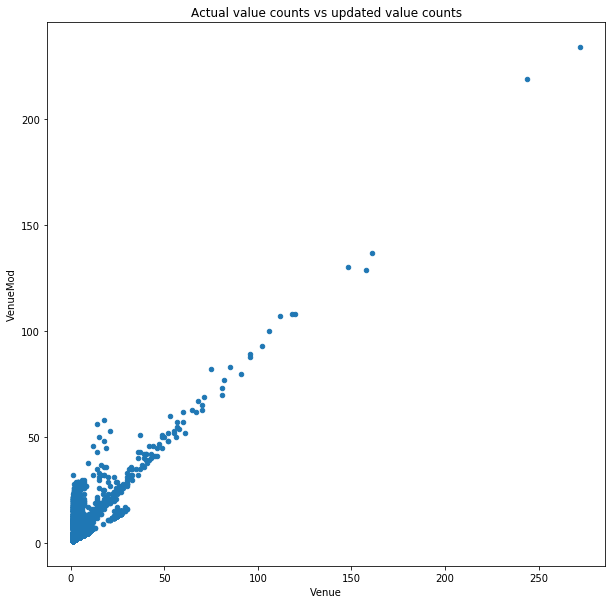

In [731]:
ndf = venues.groupby(['Neighborhood','Venue Category']).mean()
ndf['Venue'] = venues.groupby(['Neighborhood','Venue Category']).count()['Venue']
ndf.reset_index(inplace=True) 

x = pd.DataFrame(venues.groupby(['Neighborhood']).count()['Venue'] == 100)
x.reset_index(inplace=True) 
x.columns = ['Neighborhood','VenueCap']
ndf = ndf.merge(x,on='Neighborhood')

ndfSub = ndf[ndf['VenueCap']==False]

# Create the aggregate dataset and analyse it
ndfSub = ndf.groupby(['Neighborhood','Venue Category','VenueCap']).mean()
ndfSub['Venue'] = ndf.groupby(['Neighborhood','Venue Category','VenueCap']).sum()['Venue']
ndfSub.reset_index(inplace=True) 

# Create a copy of the population data transformed by log 2,
# this will ensure models are trained properly
scaler = MinMaxScaler()
ndfSub['PopulationMM'] = scaler.fit_transform(np.array(ndfSub['Population'].values).reshape(-1, 1))

# Encode the catagory column
enc = LabelEncoder()
enc.fit(np.array(ndf['Venue Category'].values).reshape(-1, 1))
ndfSub['Venue Category Enc'] = enc.transform(np.array(ndfSub['Venue Category'].values).reshape(-1, 1))


ndfSub = ndfSub.fillna(ndfSub.mean())


# While no linear relationship can be observed, there is a pattern.
# A random forest model will be used to adjust the capped value counts.

# Imbalanced datasets can cause issues while modeling, oversample the minority classes
ndfCapped = ndfSub[ndfSub['VenueCap']==False]

features = list(ndfCapped.columns)
features.remove('Venue')
features.remove('Population')
features.remove('Venue Category')
features.remove('Neighborhood')

#ndfSub = pd.concat([df_upsample, ndfSub])

X = ndfCapped[features] # np.array(ndfSub['PopulationMM'].values).reshape(-1, 1)
y = ndfCapped['Venue']
oversample = RandomOverSampler(sampling_strategy='minority')
X, y = oversample.fit_resample(X, y)

# Train the model
model = RandomForestRegressor()
model.fit(X,y)

# Update the existing values
X = ndfSub[features]
ndfSub['VenuesLM'] = model.predict(X)
ndfSub['VenueMod'] = np.round((ndfSub['VenuesLM']+ndfSub['Venue'])/2)

#Plot the changes
matplotlib.rcParams['figure.figsize'] = [10, 10]
ndfSub.plot(kind='scatter',x='Venue',y='VenueMod',title='Actual value counts vs updated value counts')

In [750]:
nhList = ndfSub['Neighborhood'].unique()
selNh = widgets.Dropdown(
    options=nhList,
    value=nhList[0],
    description='Neighborhood:',
    disabled=False,
)

In [795]:
ndfSub
str(int(ndfSub['Population'].mean()))

'23721'

In [768]:
currNh = ndfSub[ndfSub['Neighborhood'] == selNh.value]

Ahuntsic Central has a total population of 18692 and 77 venues.


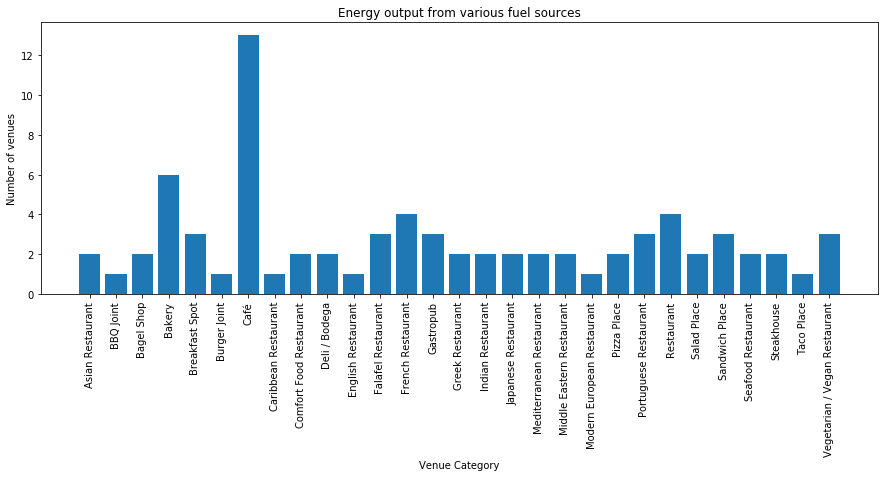

In [794]:
matplotlib.rcParams['figure.figsize'] = [15, 5]
x = currNh['Venue Category']
y = currNh['VenueMod']

catCounts = dict(zip(x, y))
maxCat = max(catCounts.items(), key=operator.itemgetter(1))



print(str(selNh.value) +
      ' has a total population of '+
      str(int(currNh['Population'].mean())) + ' and ' +
     str(int(currNh['VenueMod'].sum())) + ' venues.')



x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y)
plt.xlabel("Venue Category",)
plt.ylabel("Number of venues")
plt.title("Energy output from various fuel sources")

plt.xticks(x_pos, x,rotation=90)

plt.show()



('Café', 13.0)

In [791]:
int(currNh['Population'].mean())

18692

In [774]:
currNh

,Neighborhood,Venue Category,VenueCap,Neighborhood Latitude,Neighborhood Longitude,Population,Venue Latitude,Venue Longitude,Age characteristics 15 years_x,Age characteristics 16 years_x,...,Population and dwelling counts Population density per square kilometre_y,Population and dwelling counts Population in 2006_y,Population and dwelling counts Population in 2011_y,Population and dwelling counts Private dwellings occupied by usual residents_y,Population and dwelling counts Total private dwellings_y,Venue,PopulationMM,Venue Category Enc,VenuesLM,VenueMod
0,Ahuntsic Central,Asian Restaurant,True,45.5606,-73.6584,18692.0,45.563244,-73.636094,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,3,0.134351,2,1.79,2.0
1,Ahuntsic Central,BBQ Joint,True,45.5606,-73.6584,18692.0,45.531409,-73.613039,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,1,0.134351,3,1.69,1.0
2,Ahuntsic Central,Bagel Shop,True,45.5606,-73.6584,18692.0,45.524625,-73.592096,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,3,0.134351,4,1.69,2.0
3,Ahuntsic Central,Bakery,True,45.5606,-73.6584,18692.0,45.532276,-73.611603,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,10,0.134351,5,1.69,6.0
4,Ahuntsic Central,Breakfast Spot,True,45.5606,-73.6584,18692.0,45.536521,-73.607515,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,4,0.134351,8,1.86,3.0
5,Ahuntsic Central,Burger Joint,True,45.5606,-73.6584,18692.0,45.518011,-73.581671,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,1,0.134351,10,1.70,1.0
6,Ahuntsic Central,Café,True,45.5606,-73.6584,18692.0,45.525748,-73.594459,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,25,0.134351,12,1.72,13.0
7,Ahuntsic Central,Caribbean Restaurant,True,45.5606,-73.6584,18692.0,45.519787,-73.562220,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,1,0.134351,14,1.71,1.0
8,Ahuntsic Central,Comfort Food Restaurant,True,45.5606,-73.6584,18692.0,45.533686,-73.619291,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,1,0.134351,17,2.00,2.0
9,Ahuntsic Central,Deli / Bodega,True,45.5606,-73.6584,18692.0,45.520236,-73.586513,93910.0,95980.0,...,168476.9,7546131.0,7903001.0,3395343.0,3685926.0,2,0.134351,19,1.80,2.0


In [735]:
# is opening a food idea here good?

## A description of the problem and a discussion of the background.

The success of a new business depends on a number of factors, one of them is to perform market research. Market research allows a prospective business owner to identify gaps in supply as well as determine if an area has demand for their goods. Doing this research will ensure a new business is set up for success and their hard work does not go to waste, however it is currently very time consuming.

This project aims to identify demand for diffrent types of cuisines based on availability and population demand. The findings will allow new restaurant owners to decide what type of food they will serve

Note: For the purpose of this project, and scope of this project will only target Canada and be limited to food items.

## A description of the data and how it will be used to solve the problem.

This project will utilize data from several sources:
1. Geospatial data will be gatherd from www.geonames.org
2. Census data from Statistics Canada https://www.statcan.gc.ca/
3. Current business/venue data from https://foursquare.com/

The geospatial and census data will be combined to form a larger dataset, the data will be joined by post code. Finally the FourSquare API will be used to identify restaurants within a 10KM radius. The responses from FourSquare will be cached due to rate limitations on the API.

Once all of the data has been gatherd, analysis can be preformed to identify the best types of cuisines for a new business to sell.


In [7]:

geoCols = ['country code','postal code','place name',
           'state name','state code',
           'admin name2','admin code2',
           'admin name3','admin code3',
           'latitude','longitude','accuracy']
geospatialdf = pd.read_csv('Data/CA.csv',names=geoCols,header=None)


,country code,postal code,place name,state name,state code,admin name2,admin code2,admin name3,admin code3,latitude,longitude,accuracy
0,CA,T0A,Eastern Alberta (St. Paul),Alberta,AB,NaN,NaN,NaN,NaN,54.7660,-111.7174,6.0
1,CA,T0B,Wainwright Region (Tofield),Alberta,AB,NaN,NaN,NaN,NaN,53.0727,-111.5816,6.0
2,CA,T0C,Central Alberta (Stettler),Alberta,AB,NaN,NaN,NaN,NaN,52.1431,-111.6941,5.0
3,CA,T0E,Western Alberta (Jasper),Alberta,AB,NaN,NaN,NaN,NaN,53.6758,-115.0948,5.0
4,CA,T0G,North Central Alberta (Slave Lake),Alberta,AB,NaN,NaN,NaN,NaN,55.6993,-114.4529,6.0


In [8]:
censusdf = pd.read_csv('Data/CanadaPopByPostCode.CSV')
censusdf.head()

,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,1,Canada,NaN,T,35151728.0,15412443.0,14072079.0
1,A0A,A0A,Newfoundland and Labrador,NaN,46587.0,26155.0,19426.0
2,A0B,A0B,Newfoundland and Labrador,NaN,19792.0,13658.0,8792.0
3,A0C,A0C,Newfoundland and Labrador,NaN,12587.0,8010.0,5606.0
4,A0E,A0E,Newfoundland and Labrador,NaN,22294.0,12293.0,9603.0


In [ ]:
www.geonames.org
https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A

In [167]:
ca = np.array(['A : sad','B : sad','C : sad','D : sad','E : sad'])
cad = ca

In [173]:
cad = [x.split(':')[0] for x in ca]
cad = np.array(cad)
cad = pd.DataFrame(cad)
cad.columns=['test']

In [171]:
dogs = np.unique(ca)
keys = [x.split(':')[0] for x in dogs]
new_dict = dict(zip(keys, dogs))
new_dict

{'A ': 'A : sad',
 'B ': 'B : sad',
 'C ': 'C : sad',
 'D ': 'D : sad',
 'E ': 'E : sad'}

In [174]:
cad['test'] = [new_dict[x] for x in cad['test']]
cad

,test
0,A : sad
1,B : sad
2,C : sad
3,D : sad
4,E : sad
